In [1]:
import os
import sys
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import optimize

src_path = pathlib.Path.joinpath(pathlib.Path(os.getcwd()), "src")
print(f"Appending '{src_path}' to path")
sys.path.append(str(src_path))
from thermal_model.estimation import lti_from_data
from thermal_model.estimation.models import generate_evaluation
from thermal_model.models import generated_heat_from_current


DATA_DIR = os.path.join("data_raw")
FORK_DIR = os.path.join(DATA_DIR, "forklift", "Lithium-ion battery degradation dataset based on a realistic forklift operation profile")


def convert_size(size_bytes):
    # Convert bytes to KB, MB, GB, TB
    power = 1024
    size_types = ["B", "KB", "MB", "GB", "TB"]
    size = size_bytes / power
    i = 0
    while size >= power:
        size /= power
        i += 1
    return "{:.2f} {}".format(size, size_types[i])


Appending 'c:\Users\Cristobal\Cosas\Trabajos\CASE\Monorepo\battery-temperature-modelling\src' to path


In [2]:
CELL = 1
CELL_DIR = os.path.join(FORK_DIR, f"Cell{CELL}")
AMB_TEMPS = {
    1: 45,
    2: 40,
    3: 35,
}
constant_ambient_temperature = AMB_TEMPS[CELL]

rounds = os.listdir(CELL_DIR)
rounds.sort()
rpt = pd.DataFrame()
age = pd.DataFrame()
for r in tqdm(rounds[:None], "Reading files"):
    csv_files = os.listdir(os.path.join(CELL_DIR, r))
    if (n := "RPT.csv") in csv_files:
        rpt = pd.concat([rpt, pd.read_csv(os.path.join(CELL_DIR, r, n))])
    if (n := "Ageing.csv") in csv_files:
        age = pd.concat([age, pd.read_csv(os.path.join(CELL_DIR, r, n))])

display(rpt)
display(age)
print(f"RPT: {convert_size(rpt.memory_usage(deep=True).sum())}")
print(f"AGE: {convert_size(age.memory_usage(deep=True).sum())}")


Reading files: 100%|██████████| 58/58 [00:30<00:00,  1.89it/s]


,Cell,Round,Time,Current,Voltage,Energy,Temperature
0,1,0,0.150,0.0,3.3378,0.0000,24.754
1,1,0,1.178,0.0,3.3378,0.0000,24.754
2,1,0,2.095,0.0,3.3378,0.0000,24.878
3,1,0,12.107,0.0,3.3378,0.0000,24.893
4,1,0,22.105,0.0,3.3378,0.0000,24.863
...,...,...,...,...,...,...,...
94373,1,58,120510.411,0.0,3.3699,226.7208,31.759
94374,1,58,120520.420,0.0,3.3671,226.7208,31.872
94375,1,58,120520.420,0.0,3.3671,226.7208,31.872
94376,1,58,120520.440,0.0,3.3671,226.7208,31.872


,Cell,Round,Part,Time,Current,Voltage,Energy,Temperature
0,1,1,1.0,0.000,0.0000,3.3383,0.0000,44.862
1,1,1,1.0,3.133,-2.9977,3.3378,-0.0027,44.892
2,1,1,1.0,4.126,-20.9992,3.3341,-0.0200,44.892
3,1,1,1.0,5.146,-44.9995,3.3289,-0.0605,44.847
4,1,1,1.0,6.120,-32.9985,3.3305,-0.0885,44.847
...,...,...,...,...,...,...,...,...
589041,1,58,2.0,593140.143,19.9997,3.3355,134.7707,43.930
589042,1,58,2.0,593141.119,19.9997,3.3355,134.7895,43.930
589043,1,58,2.0,593142.128,19.9980,3.3355,134.8075,43.930
589044,1,58,2.0,594053.154,-0.0017,3.3102,134.8121,43.939


RPT: 344.68 KB
AGE: 2.04 MB


In [3]:
base = rpt
r_train = 10
r_eval = 20
df_train = base[base["Round"] == r_train]
df_eval = base[base["Round"] == r_eval]


def get_data(df):
    # Data extractable from dataset
    surf = df["Temperature"].to_numpy()
    t = np.arange(len(surf)) + 1
    curr = df["Current"].to_numpy()
    amb = constant_ambient_temperature * np.ones(len(surf))

    # Secondary data
    resistance = (df["Voltage"] / df["Current"])
    internal_resistance = resistance[resistance != np.inf].max()
    soc = np.array([curr[:i].sum() / (3600 * 180) for i, _ in enumerate(curr)])
    soc = soc - soc.min()
    qgen = generated_heat_from_current(curr, surf, soc, internal_resistance)

    # Data assembly
    y = np.array([
        surf,
    ]).T
    u = np.array([
        amb,
        qgen,
    ]).T
    x0 = np.array([surf[0], surf[0]])
    return y, u, t, x0


y_train, u_train, t_train, x0_train = get_data(df_train)
y_eval, u_eval, t_eval, x0_eval = get_data(df_eval)


In [4]:
def optimizer_callback(intermediate_result):
    print(f"\rTarget function: {intermediate_result.fun}             ", end="")


print("Starting minimization\n")
(A, B, C, _), params = lti_from_data(y_train, u_train, t_train, x0_train, 0, 0,
                                     optimizer_fn=optimize.minimize,
                                     system_kwargs={
                                         "outputs": "sf",
                                     }, optimizer_kwargs={
                                         "method": "L-BFGS-B",
                                         "callback": optimizer_callback,
                                     },
                                     )
print("\n")
print(f"Final parameters: {params}")
print(f"A = \n{A}")
print(f"B = \n{B}")
print(f"C = \n{C}")

print(f"Continous poles: {np.linalg.eig(A)[0]}")

if np.linalg.matrix_rank(np.vstack([C, C @ A])) != 2:
    print("!!! SYSTEM IS NOT OBSERVABLE !!!")

Starting minimization



c:\Users\Cristobal\.conda\envs\case\Lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


MemoryError: Unable to allocate 85.7 GiB for an array with shape (107222, 107222) and data type float64

MSE: [41059.06258424  7238.54366116]


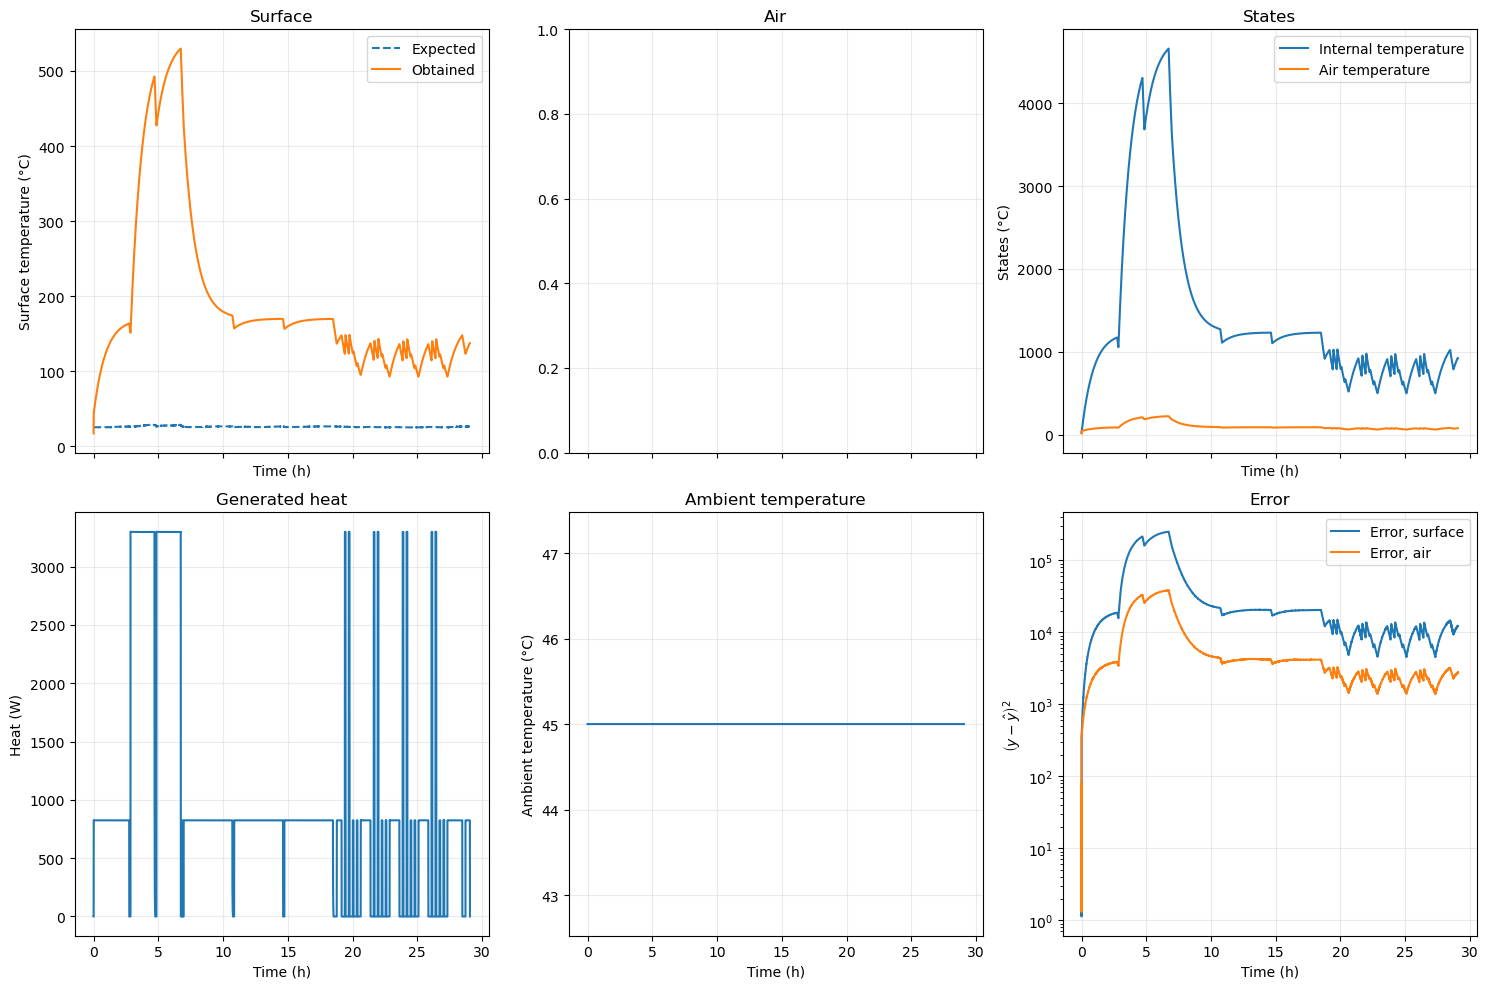

In [ ]:
evaluate = generate_evaluation(y_eval, u_eval, t_eval, x0_eval)
expected, obtained, error, x = evaluate(params)
# expected, obtained, error, x = evaluate(BEST_PARAMS)
error_square = error ** 2
mse = np.diag(error.conjugate().T @ error) / len(error)
print(f"MSE: {mse}")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

ax1.plot(t_eval / 3600, expected, label="Expected", linestyle="--")
ax1.plot(t_eval / 3600, obtained[:, 0], label="Obtained")
# ax2.plot(t_eval / 3600, expected, label="Expected", linestyle="--")
# ax2.plot(t_eval / 3600, obtained[:, 1], label="Obtained")
ax3.plot(t_eval / 3600, x[:, 0], label="Internal temperature")
ax3.plot(t_eval / 3600, x[:, 1], label="Air temperature")

ax4.plot(t_eval / 3600, u_eval[:, 1], label="Generated heat")
ax5.plot(t_eval / 3600, u_eval[:, 0], label="Ambient temperature")
ax6.plot(t_eval / 3600, error_square[:, 0], label="Error, surface")
ax6.plot(t_eval / 3600, error_square[:, 1], label="Error, air")

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Surface temperature (°C)")
# ax2.set_xlabel("Time (h)")
# ax2.set_ylabel("Air temperature (°C)")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("States (°C)")
ax4.set_xlabel("Time (h)")
ax4.set_ylabel("Heat (W)")
ax5.set_xlabel("Time (h)")
ax5.set_ylabel("Ambient temperature (°C)")
ax6.set_xlabel("Time (h)")
ax6.set_ylabel("$\\left(y - \\hat y\\right)^2$")

ax1.set_title("Surface")
ax2.set_title("Air")
ax3.set_title("States")
ax6.set_title("Error")
ax4.set_title("Generated heat")
ax5.set_title("Ambient temperature")

ax1.legend()
# ax2.legend()
ax3.legend()
ax6.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)
ax4.grid(alpha=0.25)
ax5.grid(alpha=0.25)
ax6.grid(alpha=0.25)

ax6.set_yscale("log")

fig.tight_layout()
plt.show()